In [18]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from  matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor


Cite your source of data. (Remember to include your data as a comma separated value (CSV) file with your submission.

In [2]:
# Import dataset
df = pl.read_csv("project1_2008_all.csv")

# Read more csv's and concatenate (Optional)
df2 = pl.read_csv("project1_2009_all.csv")
df = pl.concat([df, df2])

# Add goal_differential column to the dataframe
df = df.with_columns(
    (pl.col("goals_scored") - pl.col("goals_allowed")).alias("goal_differential")
)

# Convert 'col1' from float64 to int16 Future opitmization
# df = df.with_columns([
#     pl.col('goals_scored').cast(pl.Int16),  # Cast column from float64 to int16
# ])

df

match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272481,3611,5,7,8,13,25,14,27,42,6,8,25,27,17,21,26,16,27,8,17,35,21,25,32,24,35,14,25,23,28,35,24,37,15,26,24,27,26,36,10,19,49,38,50,15,23,32,45,12,23,51,10,19,15,30,14,4.0,0.0,4.0
285809,4398,1,3,3,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,1.0,-1.0
285809,4860,1,1,1,1,1,1,1,1,1,1,13,12,9,4,3,1,1,1,1,12,9,4,3,1,1,1,1,8,4,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,1.0


In [3]:
# Set random state
random_state = 999

# Filter out rows where 'goal_differential' is NaN or null
original_rows = df.shape[0]
df = df.filter(
    pl.col("goal_differential").is_not_null()
    & pl.col("goal_differential").is_finite()
)
rows_removed = original_rows - df.shape[0]
print(f"Rows removed from df after filtering: {rows_removed}")

# Filter the dataframe to only take certain rows based on team id (Optional)
#   This would be beneficial if we only want to train our model
#   on only teams from a certain league or set of leagues

df

Rows removed from df after filtering: 40


match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272481,3611,5,7,8,13,25,14,27,42,6,8,25,27,17,21,26,16,27,8,17,35,21,25,32,24,35,14,25,23,28,35,24,37,15,26,24,27,26,36,10,19,49,38,50,15,23,32,45,12,23,51,10,19,15,30,14,4.0,0.0,4.0
285809,4398,1,3,3,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,1.0,-1.0
285809,4860,1,1,1,1,1,1,1,1,1,1,13,12,9,4,3,1,1,1,1,12,9,4,3,1,1,1,1,8,4,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,1.0


 Set aside 10% of your datapoints as a Test set. This will be used to compare the final performance of
 all the models we train. The remaining 90% of your data will be referred to as your Train/Validation
 dataset.

In [4]:
# Stratify the shuffling based on match_id
#   (This ensures we have no data leakage)
match_ids = df['match_id'].unique()

# Create a gss object to allocate 10% to test set
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)
# Split groups based on the criteria of retaining inputs for teams of the same match
train_holdout_idx, test_idx = next(gss.split(df, groups=df['match_id']))

# Split the df based on the indexes from the split
train_holdout_df = df[train_holdout_idx]
test_df = df[test_idx]

# Check percentages
print(f"Train/Holdout shape: {train_holdout_df.shape} ~{train_holdout_df.shape[0]/df.shape[0]}") # 90%
print(f"Test shape: {test_df.shape} ~{test_df.shape[0]/df.shape[0]}") # 10%

# Grab feature rows
X_columns = [f"feature_{i+1}" for i in range(55)]
y_column = ["goal_differential"]

# Set aside final test dataset
X_test, y_test = test_df[X_columns], test_df[y_column] # This is the final test dataset
# train holdout data
X_train_holdout, y_train_holdout = train_holdout_df[X_columns], train_holdout_df[y_column]

Train/Holdout shape: (50202, 60) ~0.9
Test shape: (5578, 60) ~0.1


Select a method to estimate the value of your error function on new data (Enew). We will be using Option 2: Holdout cross validation, and split the data as follows: 80% train / 20% validate.

In [5]:
gss2 = GroupShuffleSplit(n_splits=1, test_size=20/90, random_state=random_state)
train_idx, holdout_idx = next(gss2.split(train_holdout_df, groups=train_holdout_df['match_id']))
train_df = train_holdout_df[train_idx]
holdout_df = train_holdout_df[holdout_idx]

print(f"Train shape: {train_df.shape} ~{train_df.shape[0]/df.shape[0]}") # ~70% of total data
print(f"Holdout shape: {holdout_df.shape} ~{holdout_df.shape[0]/df.shape[0]}") # ~20% of total data

X_train, y_train = train_df[X_columns], train_df[y_column]
X_holdout, y_holdout = holdout_df[X_columns], holdout_df[y_column]

Train shape: (39046, 60) ~0.7
Holdout shape: (11156, 60) ~0.2


##2.2: Train Base model
Choose a base model. This will the be the model that you input into your bagging algorithm, so it
 should be a model that will perform decently well on your dataset (i.e. not random choice). Explain
 why you chose this base estimator.
 • Select a method to estimate the performance of your base estimator on new data (Enew). Clearly state
 in your writeup which method you chose.– Option 1: k-fold cross validation.– Option 2: Holdout cross validation. If you choose this method, be sure to clearly state the
 percentages you used to split the data (e.g. 80% train / 20% validate).
 • Train your base estimator on your Train / Validation dataset. Record the estimate of performance on
 Enew.
 • Perform a sweep to tune your hyperparameters for the base estimator. Try to improve the base model
 as much as possible. Record values of Enew and create plots showing evidence that you rigorously
 searched the hyperparameter space.
 • Using the best hyperparameter combination, train a final model on your Train/Validation dataset.

In [14]:
# Define the range of k-values to test. [19,23,29,37,43] [55,69,79,91] [111,163,199,251] [301,395,451,597]
k_values = [1, 31, 75,  123, 149, 179, 280, 401, 597]
# k_values = [111, 117, 121, 122, 123, 124, 127, 133, 137]
# Variables to store the best performing k and its corresponding error.
best_k = None
best_error = np.inf

# Dictionary (or list) to store results for each k.
results = {}

In [15]:
# Loop over the range of k-values.
for k in k_values:
    # Create and train the model for the current k.
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    # Predict on the holdout set.
    predictions = model.predict(X_holdout)

    # Calculate the mean squared error on the holdout set.
    mse_holdout = mean_squared_error(y_holdout, predictions)
    mse_train = mean_squared_error(y_train, model.predict(X_train))
    results[k] = (mse_train, mse_holdout)

    # Output the result for the current k.
    print(f"For k = {k}, E_train (MSE) = {mse_train:.4f} estimated E_new (MSE) = {mse_holdout:.4f}")

    # Track the best performing model.
    if mse_holdout < best_error:
        best_error = mse_holdout
        best_k = k

# Print the best k value based on holdout performance.
print(f"\nBest k found: {best_k} with an estimated E_new (MSE) = {best_error:.4f}")


For k = 1, E_train (MSE) = 0.8911 estimated E_new (MSE) = 5.6257
For k = 31, E_train (MSE) = 2.7921 estimated E_new (MSE) = 2.9549
For k = 75, E_train (MSE) = 2.8473 estimated E_new (MSE) = 2.9022
For k = 123, E_train (MSE) = 2.8608 estimated E_new (MSE) = 2.8877
For k = 149, E_train (MSE) = 2.8637 estimated E_new (MSE) = 2.8899
For k = 179, E_train (MSE) = 2.8682 estimated E_new (MSE) = 2.8895
For k = 280, E_train (MSE) = 2.8750 estimated E_new (MSE) = 2.8886
For k = 401, E_train (MSE) = 2.8802 estimated E_new (MSE) = 2.8900
For k = 597, E_train (MSE) = 2.8918 estimated E_new (MSE) = 2.8980

Best k found: 123 with an estimated E_new (MSE) = 2.8877


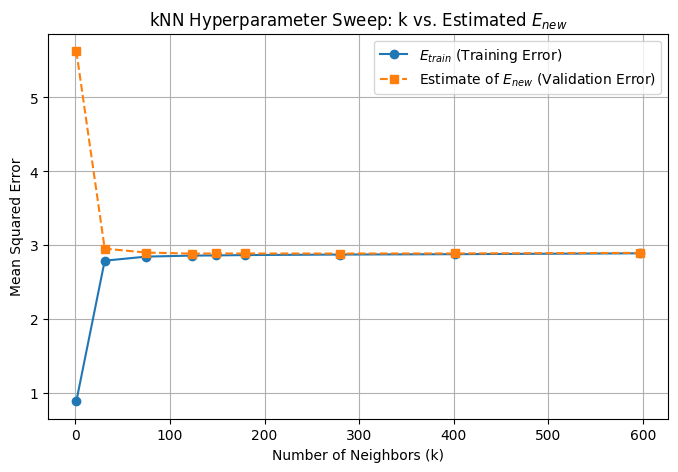

In [16]:
k_values = list(results.keys())
E_train_values = [results[k][0] for k in k_values]
E_new_values = [results[k][1] for k in k_values]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, E_train_values, marker='o', linestyle='-', label='$E_{\t{train}}$ (Training Error)')
plt.plot(k_values, E_new_values, marker='s', linestyle='--', label='Estimate of $E_{\t{new}}$ (Validation Error)')

# Labels and title
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error")
plt.title("kNN Hyperparameter Sweep: k vs. Estimated $E_{\t{new}}$")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Create the final Model
model_best_baseline = KNeighborsRegressor(
    n_neighbors=best_k
)

# Fit it on the entire dataset (both train and holdout sets)
model_best_baseline.fit(X_train_holdout, y_train_holdout)

KNeighborsRegressor(n_neighbors=123)

## 2.3 Train Bagging Estimator
 • Use sklearn’s BaggingRegressor or BaggingClassifier to create a Bagging model from your base
 estimator.– Your baseline model class will go in the estimator keyword argument of either
 BaggingRegressor or BaggingClassifier– If you are using Decision Trees, you’ll probably want to use sklearn’s Random Forest Regressor
 / Classifier rather than its Bagging Regressor / Classifier.
 • Train your base estimator on your Train / Validation dataset. Record the estimate of performance on
 Enew.
 • Perform a sweep to tune your hyperparameters for the base estimator. Try to improve the base model
 as much as possible. Record values of Enew and create plots showing evidence that you rigorously
 searched the hyperparameter space.
 • Using the best hyperparameter combination, train a final model on your Train/Validation dataset.

In [28]:
### --- Bagging Model --- ###
# Hyperparameter sweep parameters for Bagging
n_estimators_list = [10, 50, 100]
max_samples_list  = [0.5, 0.75, 0.9]
max_features_list = [0.5, 0.75, 0.9]

bagging_errors = {}

best_bagging_error = np.inf
best_n_estimators = None
best_max_samples = None
best_max_features = None

for i, n_estimators in enumerate(n_estimators_list):
    for j, max_samples in enumerate(max_samples_list):
        for k, max_features in enumerate(max_features_list):
          bag_reg = BaggingRegressor(
              estimator=model_best_baseline,
              n_estimators=n_estimators,
              max_samples=max_samples,
              max_features=max_features,
              random_state=random_state,
              n_jobs = -1
          )
          bag_reg.fit(X_train, y_train.to_numpy().ravel())
          predictions = bag_reg.predict(X_holdout)
          mse_holdout = mean_squared_error(y_holdout, predictions)
          bagging_errors[(n_estimators, max_samples, max_features)] = (mse_train, mse_holdout)
          print(f"n_estimators={n_estimators}, max_samples={max_samples}, max_features={max_features}, CV MSE={mse_holdout:.4f}")
          # Track the best performing model.
          if mse_holdout < best_bagging_error:
              best_bagging_error = mse_holdout
              best_n_estimators = n_estimators
              best_max_samples = max_samples
              best_max_features = max_features


n_estimators=10, max_samples=0.5, max_features=0.5, CV MSE=2.8998
n_estimators=10, max_samples=0.5, max_features=0.75, CV MSE=2.8940
n_estimators=10, max_samples=0.5, max_features=0.9, CV MSE=2.8916
n_estimators=10, max_samples=0.75, max_features=0.5, CV MSE=2.8975
n_estimators=10, max_samples=0.75, max_features=0.75, CV MSE=2.8963
n_estimators=10, max_samples=0.75, max_features=0.9, CV MSE=2.8918
n_estimators=10, max_samples=0.9, max_features=0.5, CV MSE=2.8963
n_estimators=10, max_samples=0.9, max_features=0.75, CV MSE=2.8926
n_estimators=10, max_samples=0.9, max_features=0.9, CV MSE=2.8907
n_estimators=50, max_samples=0.5, max_features=0.5, CV MSE=2.9102
n_estimators=50, max_samples=0.5, max_features=0.75, CV MSE=2.8897
n_estimators=50, max_samples=0.5, max_features=0.9, CV MSE=2.8857
n_estimators=50, max_samples=0.75, max_features=0.5, CV MSE=2.9069
n_estimators=50, max_samples=0.75, max_features=0.75, CV MSE=2.8917
n_estimators=50, max_samples=0.75, max_features=0.9, CV MSE=2.8863

In [30]:
print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_samples: {best_max_samples}")
print(f"Best max_features: {best_max_features}")

Best n_estimators: 50
Best max_samples: 0.5
Best max_features: 0.9


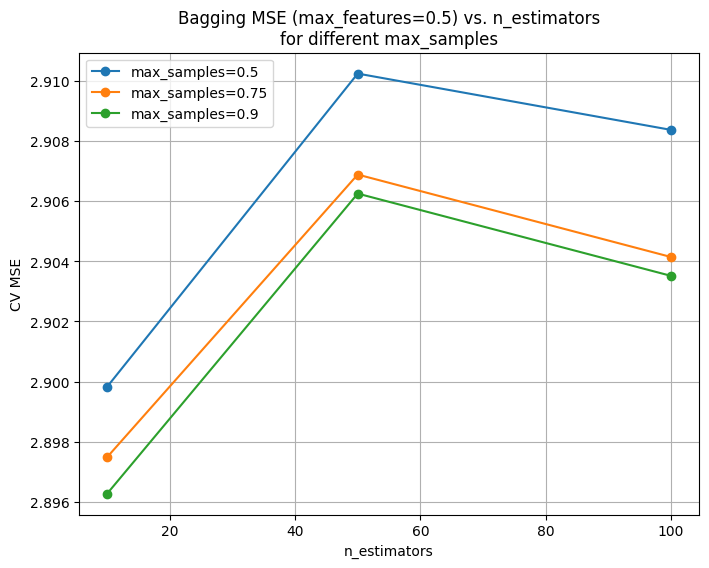

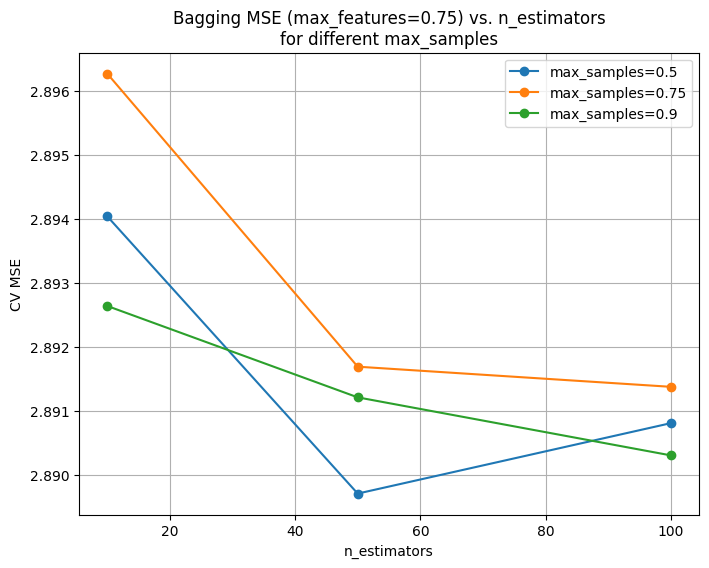

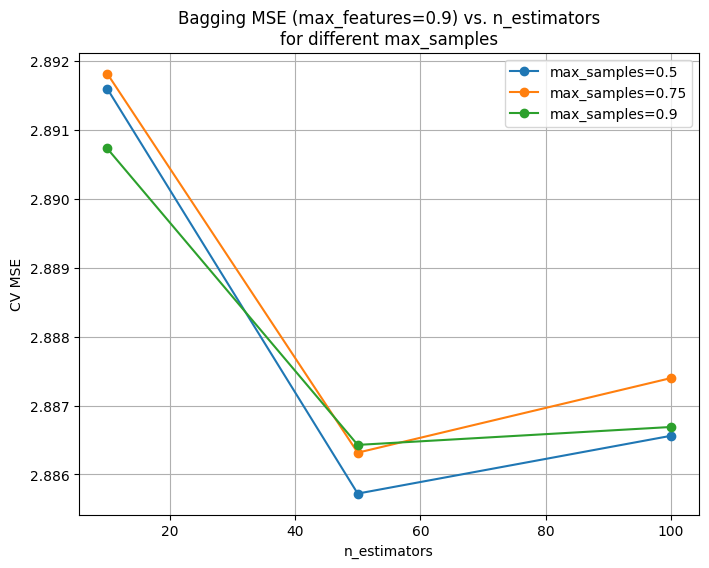

In [32]:
# Graph the results
for k, mf in enumerate(max_features_list):
    plt.figure(figsize=(8, 6))
    for j, msamp in enumerate(max_samples_list):
      x = np.array(n_estimators_list)
      y = np.array([bagging_errors[(n_estimators, msamp, mf)][1] for n_estimators in n_estimators_list])
      plt.plot(x, y, marker='o', label=f'max_samples={msamp}')
    plt.xlabel('n_estimators')
    plt.ylabel('CV MSE')
    plt.title(f'Bagging MSE (max_features={mf}) vs. n_estimators\nfor different max_samples')
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
# Train and fit best overall model
best_bagging_model = BaggingRegressor(
    estimator=model_best_baseline,
    n_estimators=best_n_estimators,
    max_samples=best_max_samples,
    max_features=best_max_features,
    random_state=random_state
)
best_bagging_model.fit(X_train, y_train.to_numpy().ravel())

BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=123),
                 max_features=0.9, max_samples=0.5, n_estimators=50,
                 random_state=999)

## 2.4 Train Model Using Boosting
 • Create a Boosting model using either an XGBoost implementation (Regressor or Classifier), or an
 sklearn implementation (see here for examples).1
 • Train your Boosting model on your Train / Validation dataset. Record the estimate of performance on
 Enew.
 • Perform a sweep to tune your hyperparameters for the base estimator. Try to improve the base model
 as much as possible. Record values of Enew and create plots showing evidence that you rigorously
 searched the hyperparameter space.
 • Using the best hyperparameter combination, train a final model on your Train/Validation dataset.

In [38]:
### --- XGBoost --- ###
# Hyperparameter sweep parameters for Boosting
n_estimators_list = [10, 50, 100, 200, 350]
learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [1, 2, 3, 5, 7, 10]

boosting_errors = {}

best_boosting_error = np.inf
best_n_estimators = None
best_lr = None
best_depth = None

# Sweep over hyper parameters
for i, n_estimators in enumerate(n_estimators_list):
    for j, lr in enumerate(learning_rates):
        for k, depth in enumerate(max_depths):
            xgb_reg = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=lr,
                max_depth=depth,
                random_state=random_state,
                verbosity=0,
                n_jobs=-1
            )
            xgb_reg.fit(X_train, y_train)
            predictions = xgb_reg.predict(X_holdout)
            mse_holdout = mean_squared_error(y_holdout, predictions)
            boosting_errors[(n_estimators, lr, depth)] = mse_holdout
            print(f"n_estimators={n_estimators}, learning_rate={lr}, max_depth={depth}, CV MSE={mse_holdout:.4f}")
            if mse_holdout < best_boosting_error:
                best_boosting_error = mse_holdout
                best_n_estimators = n_estimators
                best_lr = lr
                best_depth = depth



n_estimators=10, learning_rate=0.01, max_depth=1, CV MSE=3.0790
n_estimators=10, learning_rate=0.01, max_depth=2, CV MSE=3.0617
n_estimators=10, learning_rate=0.01, max_depth=3, CV MSE=3.0564
n_estimators=10, learning_rate=0.01, max_depth=5, CV MSE=3.0529
n_estimators=10, learning_rate=0.01, max_depth=7, CV MSE=3.0519
n_estimators=10, learning_rate=0.01, max_depth=10, CV MSE=3.0511
n_estimators=10, learning_rate=0.05, max_depth=1, CV MSE=3.0444
n_estimators=10, learning_rate=0.05, max_depth=2, CV MSE=2.9832
n_estimators=10, learning_rate=0.05, max_depth=3, CV MSE=2.9633
n_estimators=10, learning_rate=0.05, max_depth=5, CV MSE=2.9516
n_estimators=10, learning_rate=0.05, max_depth=7, CV MSE=2.9484
n_estimators=10, learning_rate=0.05, max_depth=10, CV MSE=2.9515
n_estimators=10, learning_rate=0.1, max_depth=1, CV MSE=3.0258
n_estimators=10, learning_rate=0.1, max_depth=2, CV MSE=2.9431
n_estimators=10, learning_rate=0.1, max_depth=3, CV MSE=2.9102
n_estimators=10, learning_rate=0.1, max_d

In [39]:
print(f"Best n_estimators: {best_n_estimators}")
print(f"Best learning_rate: {best_lr}")
print(f"Best max_depth: {best_depth}")

Best n_estimators: 350
Best learning_rate: 0.1
Best max_depth: 2


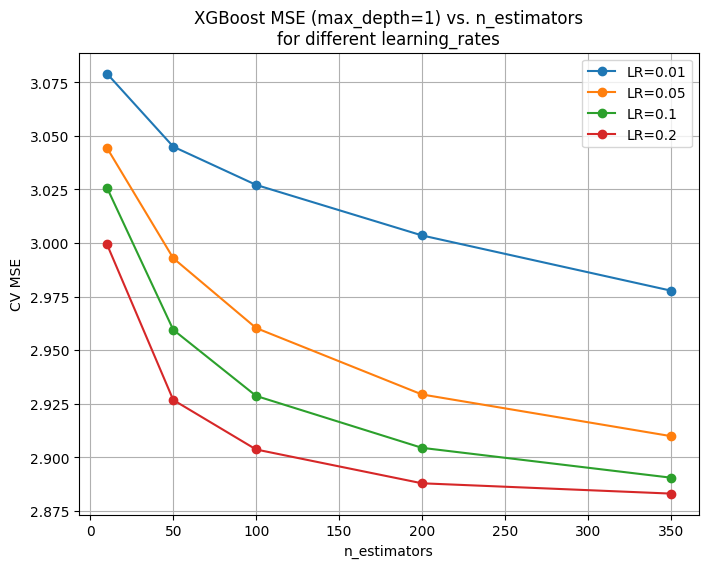

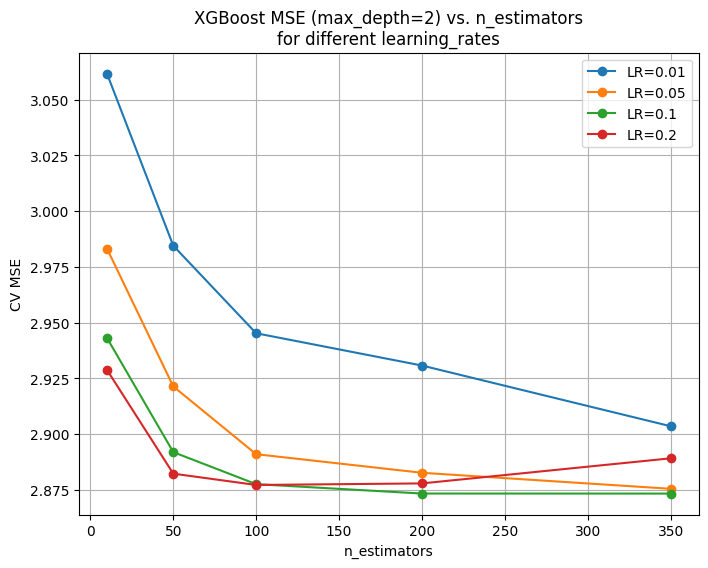

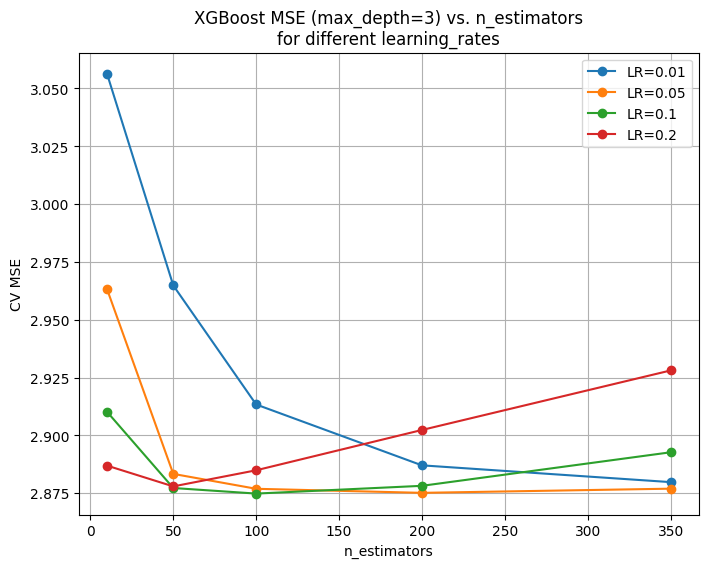

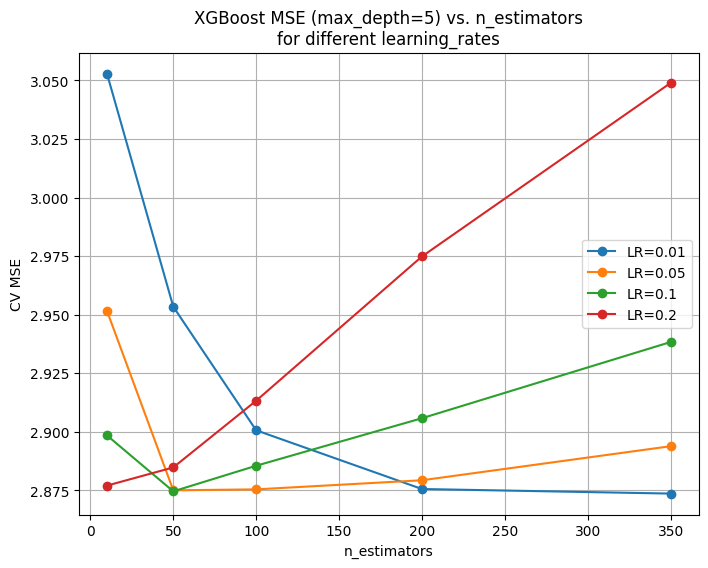

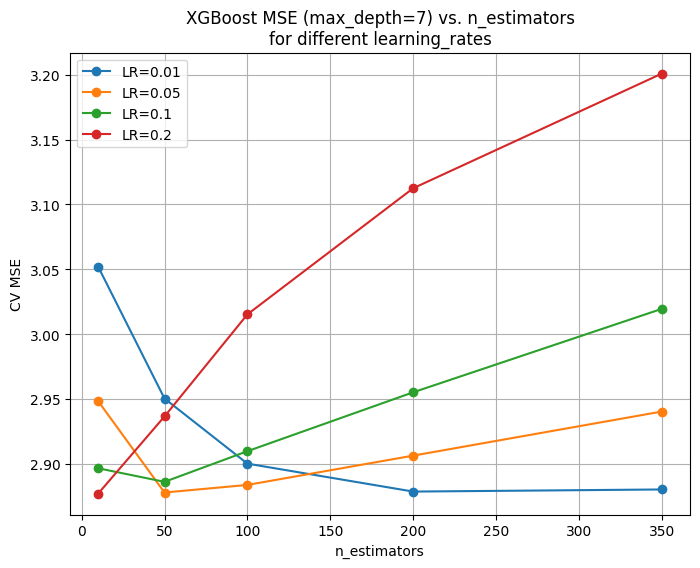

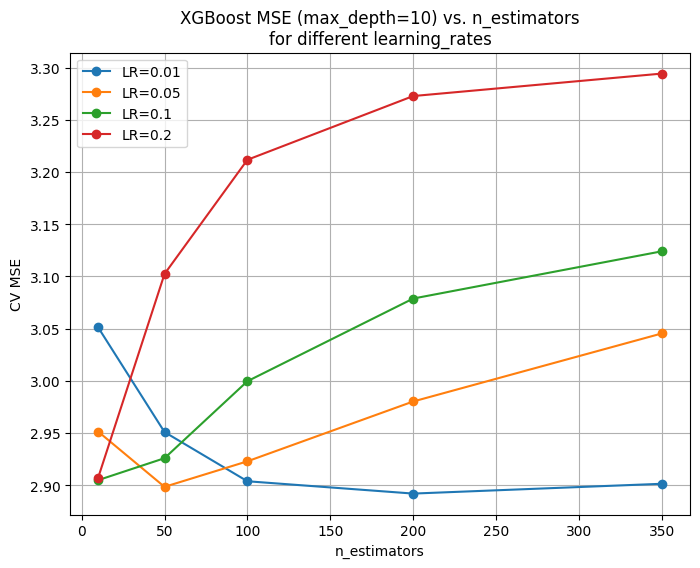

In [42]:
# Plot CV MSE vs. n_estimators for each learning_rates, for each max_depth
for k, depth in enumerate(max_depths):
    plt.figure(figsize=(8, 6))
    for j, lr in enumerate(learning_rates):
      x = np.array(n_estimators_list)
      y = np.array([boosting_errors[(n_estimators, lr, depth)] for n_estimators in n_estimators_list])
      plt.plot(x, y, marker='o', label=f'LR={lr}')
    plt.xlabel('n_estimators')
    plt.ylabel('CV MSE')
    plt.title(f'XGBoost MSE (max_depth={depth}) vs. n_estimators\nfor different learning_rates')
    plt.legend()
    plt.grid(True)
    plt.show()


In [43]:
# Train and fit best overall model
best_boosting_model = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=best_lr,
    max_depth=best_depth,
    random_state=random_state,
    verbosity=0
)
best_boosting_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=999, ...)

## 2.5 Final Testing and Comparison

In [44]:
# Test all final models on test set
predictions_baseline = model_best_baseline.predict(X_test)
mse_baseline = mean_squared_error(y_test, predictions_baseline)
print(f"Baseline Model MSE on test set: {mse_baseline:.4f}")

predictions_bagging = best_bagging_model.predict(X_test)
mse_bagging = mean_squared_error(y_test, predictions_bagging)
print(f"Bagging Model MSE on test set: {mse_bagging:.4f}")

predictions_boosting = best_boosting_model.predict(X_test)
mse_boosting = mean_squared_error(y_test, predictions_boosting)
print(f"Boosting Model MSE on test set: {mse_boosting:.4f}")


Baseline Model MSE on test set: 2.8761
Bagging Model MSE on test set: 2.8643
Boosting Model MSE on test set: 2.8664


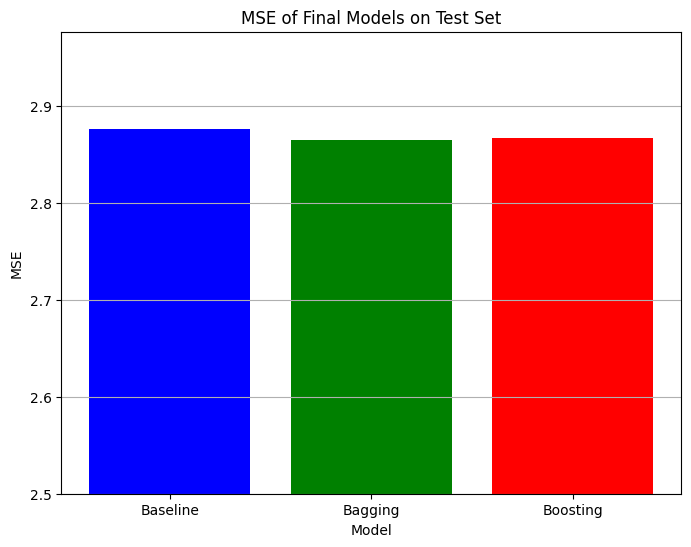

In [48]:
# plot the MSE of each model
models = ['Baseline', 'Bagging', 'Boosting']
mse_values = [mse_baseline, mse_bagging, mse_boosting]

plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('MSE of Final Models on Test Set')
plt.grid(axis='y')

plt.ylim(2.5, max(mse_values) + 0.1)
plt.show()
